# Data Space Report


<img src="images/polito_logo.png" alt="Polito Logo" style="width: 200px;"/>


## Pittsburgh Bridges Data Set

<img src="images/andy_warhol_bridge.jpg" alt="Andy Warhol Bridge" style="width: 200px;"/>

    Andy Warhol Bridge - Pittsburgh.

Report created by Student Francesco Maria Chiarlo s253666, for A.A 2019/2020.

**Abstract**:The aim of this report is to evaluate the effectiveness of distinct, different statistical learning approaches, in particular focusing on their characteristics as well as on their advantages and backwards when applied onto a relatively small dataset as the one employed within this report, that is Pittsburgh Bridgesdataset.

**Key words**:Statistical Learning, Machine Learning, Bridge Design.

### Imports Section <a class="anchor" id="imports-section"></a>

In [1]:
# =========================================================================== #
# STANDARD IMPORTS
# =========================================================================== #
print(__doc__)

# Critical Imports
# --------------------------------------------------------------------------- #
import warnings; warnings.filterwarnings("ignore")

# Imports through 'from' syntax
# --------------------------------------------------------------------------- #
from pprint import pprint
from itertools import islice
from os import listdir; from os.path import isfile, join
# Standard Imports
# --------------------------------------------------------------------------- #
import copy; import os
import sys; import time
import itertools
import sklearn

# Imports through 'as' syntax
# --------------------------------------------------------------------------- #
import numpy as np; import pandas as pd

# Imports for handling graphics
# --------------------------------------------------------------------------- #
%matplotlib inline
# Matplotlib pyplot provides plotting API
import matplotlib as mpl
from matplotlib import pyplot as plt
import chart_studio.plotly.plotly as py
import seaborn as sns;  sns.set(style="ticks", color_codes=True) # sns.set()

Automatically created module for IPython interactive environment


In [2]:
# =========================================================================== #
# UTILS IMPORTS (Done by myself)
# =========================================================================== #
from utils.load_dataset_pittsburg_utils import load_brdiges_dataset; from utils.display_utils import *
from utils.preprocessing_utils import *; from utils.training_utils import *
from utils.sklearn_functions_custom import *; from utils.learning_curves_custom import *
from utils.training_utils_v2 import fit_by_n_components, fit_all_by_n_components, grid_search_all_by_n_components

In [3]:
# =========================================================================== #
# sklearn IMPORT
# =========================================================================== #
from sklearn.decomposition import PCA, KernelPCA

# Import scikit-learn classes: models (Estimators).
from sklearn.naive_bayes import GaussianNB, MultinomialNB   # Non-parametric Generative Model
from sklearn.linear_model import LogisticRegression         # Parametric Linear Discriminative Model
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC                          # Parametric Linear Discriminative "Support Vector Classifier"
from sklearn.tree import DecisionTreeClassifier      # Non-parametric Model
from sklearn.ensemble import RandomForestClassifier  # Non-parametric Model (Meta-Estimator, that is, an Ensemble Method)

In [4]:
# =========================================================================== #
# READ INPUT DATASET
# =========================================================================== #

dataset_path = 'C:\\Users\\Francesco\Documents\\datasets\\pittsburgh_dataset'
dataset_name = 'bridges.data.csv'

TARGET_COL = 'T-OR-D'  # Target variable name
dataset, feature_vs_values = load_brdiges_dataset(dataset_path, dataset_name)

In [5]:
columns_2_avoid = ['ERECTED', 'LENGTH', 'LOCATION']

In [6]:
# Make distinction between Target Variable and Predictors
# --------------------------------------------------------------------------- #

columns = dataset.columns  # List of all attribute names

# Get Target values and map to 0s and 1s
# y = np.array(list(map(lambda x: 0 if x == 1 else 1, dataset[TARGET_COL].values)))
y = np.array(list(map(lambda x: -1 if x == 1 else 1, dataset[TARGET_COL].values)))
print('Summary about Target Variable {target_col}')
print('-' * 50)
print(dataset[TARGET_COL].value_counts())

# Get Predictors
X = dataset.loc[:, dataset.columns != TARGET_COL].values

Summary about Target Variable {target_col}
--------------------------------------------------
2    57
1    13
Name: T-OR-D, dtype: int64


In [7]:
# Standardizing the features
# --------------------------------------------------------------------------- #
scaler_methods = ['minmax', 'standard', 'norm']
scaler_method = 'standard'
rescaledX = preprocessing_data_rescaling(scaler_method, X)

shape features matrix X, after normalizing:  (70, 11)


## Pricipal Component Analysis

In [8]:
n_components = rescaledX.shape[1]
pca = PCA(n_components=n_components)
# pca = PCA(n_components=2)

# X_pca = pca.fit_transform(X)
pca = pca.fit(rescaledX)
X_pca = pca.transform(rescaledX)

In [9]:
print(f"Cumulative varation explained(percentage) up to given number of pcs:")

tmp_data = []
principal_components = [pc for pc in '2,5,6,7,8,9,10'.split(',')]
for _, pc in enumerate(principal_components):
    n_components = int(pc)
    
    cum_var_exp_up_to_n_pcs = np.cumsum(pca.explained_variance_ratio_)[n_components-1]
    # print(f"Cumulative varation explained up to {n_components} pcs = {cum_var_exp_up_to_n_pcs}")
    # print(f"# pcs {n_components}: {cum_var_exp_up_to_n_pcs*100:.2f}%")
    tmp_data.append([n_components, cum_var_exp_up_to_n_pcs * 100])

tmp_df = pd.DataFrame(data=tmp_data, columns=['# PCS', 'Cumulative Varation Explained (percentage)'])
tmp_df.head(len(tmp_data))

Cumulative varation explained(percentage) up to given number of pcs:


,# PCS,Cumulative Varation Explained (percentage)
0,2,47.738342
1,5,75.856460
2,6,82.615768
3,7,88.413903
4,8,92.661938
5,9,95.976841
6,10,98.432807


#### Major Pros & Cons of PCA



## Learning Models <a class="anchor" id="learning-models"></a>

In [10]:
# Parameters to be tested for Cross-Validation Approach

# estimators_list = [GaussianNB(), LogisticRegression(), KNeighborsClassifier(), SGDClassifier(), SVC(), DecisionTreeClassifier(), RandomForestClassifier()]
estimators_list = [GaussianNB(), LogisticRegression(random_state=0), KNeighborsClassifier(), SGDClassifier(random_state=0), SVC(random_state=0), DecisionTreeClassifier(random_state=0), RandomForestClassifier(random_state=0)]
estimators_names = ['GaussianNB', 'LogRegr', 'Knn', 'SGD', 'SVC', 'DecisionTree', 'RandomForest']
plots_names = list(map(lambda xi: f"{xi}_learning_curve.png", estimators_names))

pca_kernels_list = ['linear', 'poly', 'rbf', 'cosine', 'sigmoid']
cv_list = [10, 9, 8, 7, 6, 5, 4, 3, 2]

parmas_logistic_regression = {
    'penalty': ('l1', 'l2', 'elastic', None),
    'solver': ('newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'),
    'fit_intercept': (True, False),
    'tol': (1e-4, 1e-3, 1e-2),
    'class_weight': (None, 'balanced'),
    'C': (10.0, 1.0, .1, .01, .001, .0001),
    # 'random_state': (0,),
}


parmas_knn_forest = {
    'n_neighbors': (2,3,4,5,6,7,8,9,10),
    'weights': ('uniform', 'distance'),
    'metric': ('euclidean', 'minkowski', 'manhattan'),
    'leaf_size': (5, 10, 15, 30),
    'algorithm': ('ball_tree', 'kd_tree', 'brute'),
    # 'random_state': (0,),
}

parameters_sgd_classifier = {
    'loss': ('log', 'modified_huber'), # ('hinge', 'log', 'modified_huber', 'squared_hinge', 'perceptron')
    'penalty': ('l2', 'l1', 'elasticnet'),
    'alpha': (1e-1, 1e-2, 1e-3, 1e-4),
    'max_iter': (50, 100, 150, 200, 500, 1000, 1500, 2000, 2500),
    'learning_rate': ('optimal',),
    'tol': (None, 1e-2, 1e-4, 1e-5, 1e-6)
    # 'random_state': (0,),
}

kernel_type = 'svm-rbf-kernel'
parameters_svm = {
    'gamma': (0.003, 0.03, 0.05, 0.5, 0.7, 1.0, 1.5),
    'max_iter':(1e+2, 1e+3, 2 * 1e+3, 5 * 1e+3, 1e+4, 1.5 * 1e+3),
    # 'penalty': ('l2','l1'),
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid',],
    'C': (1e-4, 1e-3, 1e-2, 0.1, 1.0, 10, 1e+2, 1e+3),
    'probability': (True,), 
    # 'random_state': (0,),
}

parmas_decision_tree = {
    'splitter': ('random', 'best'),
    'criterion':('gini', 'entropy'),
    'max_features': (None, 'sqrt', 'log2'),
    'max_depth': (None, 3, 5, 7, 10,),
    'splitter': ('best', 'random',),
    'class_weight': (None, 'balanced'),
    'min_samples_leaf': (1,2,3,4,5),
    # 'random_state': (0,),
}

parmas_random_forest = {
    'n_estimators': (3, 5, 7, 10, 30, 50, 70, 100, 150, 200),
    'criterion':('gini', 'entropy'),
    'bootstrap': (True, False),
    'min_samples_leaf': (1,2,3,4,5),
    'max_features': (None, 'sqrt', 'log2'),
    'max_depth': (None, 3, 5, 7, 10,),
    'class_weight': (None, 'balanced', 'balanced_subsample'),
    # 'random_state': (0,),
}

param_grids = [parmas_logistic_regression, parmas_knn_forest, parameters_sgd_classifier, parameters_svm, parmas_decision_tree, parmas_random_forest]

N_CV, N_KERNEL, N_GS = 9, 4, 6

In [11]:
n_components=9
learning_curves_by_kernels(
# learning_curves_by_components(
    estimators_list[:], estimators_names[:],
    rescaledX, y,
    train_sizes=np.linspace(.1, 1.0, 10),
    n_components=9,
    pca_kernels_list=pca_kernels_list[0],
    verbose=0,
    by_pairs=True,
    savefigs=True,
    scoring='accuracy',
    figs_dest=os.path.join('figures', 'learning_curve', f"Pcs_{n_components}"), ignore_func=True,
    # figsize=(20,5)
)

In [12]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

Kernel PCA: Linear | SGD
[*] Best Score:
0.9464285714285715


Classification score 0.7222222222222222 (pvalue : 0.15841584158415842)


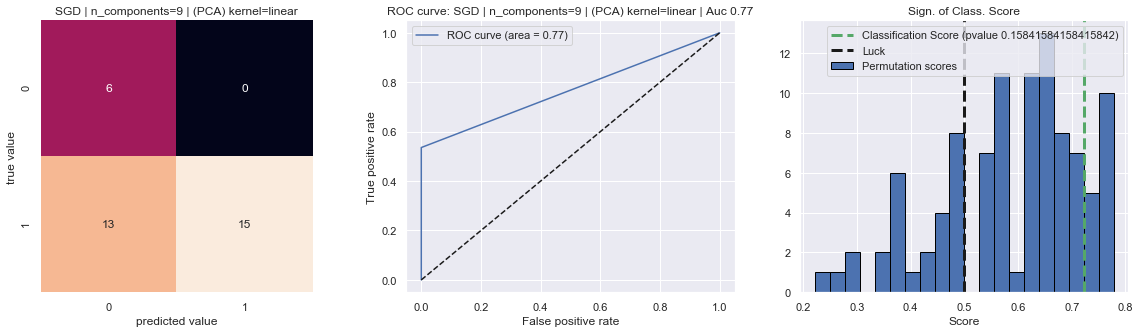

Kernel PCA: Poly | SGD
[*] Best Score:
0.9464285714285715


Classification score 0.75 (pvalue : 0.07920792079207921)


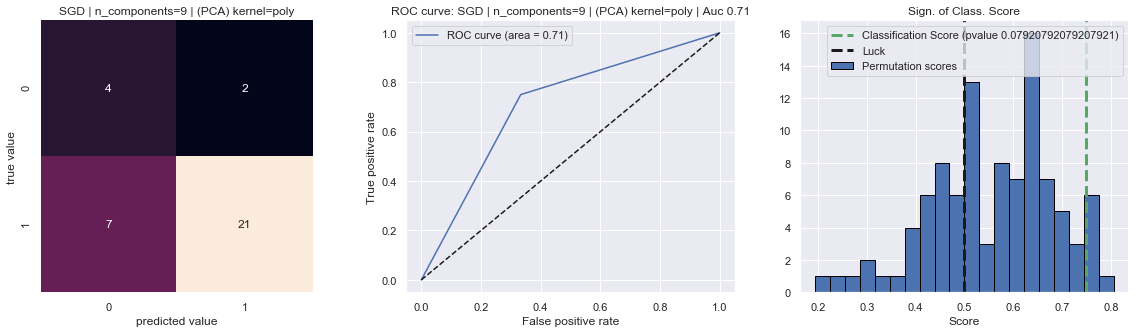

Kernel PCA: Rbf | SGD


In [ ]:
plot_dest = os.path.join("figures", "n_comp_9_analysis", "grid_search")
X = rescaledX; pos = 3

df_gs, df_auc_gs = grid_search_all_by_n_components(
    estimators_list=estimators_list[pos], \
    param_grids=param_grids[pos - 1],
    estimators_names=estimators_names[pos], \
    X=X, y=y,
    n_components=9,
    random_state=0, show_plots=False, show_errors=False, verbose=1, plot_dest=plot_dest, debug_var=False)
df_9, df_9_auc = df_gs, df_auc_gs

Looking at the results obtained running *Sgd Classifier* against our dataset splitted into training set and test set and adopting a different kernel trick applied to *kernel-Pca* unsupervised preprocessing method we can state generally speaking that looking at the weighted values of *Recall, Precision, and F1-Scores* we obtained good performance and and except for one trial where we got lower and worst results, when *Polynomial and Rbf Tricks* is selected, in the remaning cases have gotten remarkable results. More precisely we can say what follows:

- speaking about __Linear kernel Pca based Sgd Classifier__, when adoping the default threshold of *.5* for classification purposes we have a model that reaches an accuracy of *65%* at test time against an accuracy of *92%* at train step, while the Auc score reaches a value of *79%* with a Roc Curve that shows a behavior for which the model increases its *TPR* without affecting the *FPR* score, however at  a given point the Roc Curve trend turns so that the two cited scores begin to increase linearly and with a slope lower than that of Random Classifier so that FPR increases faster. The model is very precise when predicting class 1 instances but it has a recall of just *53%* so misclassified more or less half of samples from class 1 and this fact influenced instead the precision of class 0 that is really lo, just *14%*, while class 0 recall is very high. Since the test accuracy score loses nearly 30 percent points we can assume that sucha model quite overfit to train data, we are not really encouraged to adopt it except we decied to exploit it for including it in an ensemble classifier, more boosting like than bagging one.

- observing __Polynomial kernel Pca based Sgd Estimator__, we can notice that such a model exploiting a default threshold of *.5* reaches an accuracy of *74%* at test time against an accuracy of *89%* at train step, while the Auc score reaches a value of *48%*. In particular such a trial along with the *Rbf kernel Pca based Sgd Classifier* are the two attempts that lead to worts results, since the model overfit against the data employed at training time, but also the model gained weights that tend to predict every thing as class 1 instance. So, the resulting scores tell us that the model is highly precise and obtained high recall related to class 1, convercely has very low performance for precision and recall referred to class 0. Furthermmore, Roc Curve performance is slightly better the performance we know from the Random Classifier model. Since such a model is performing even worts than random classifier, we cannot adopt it in any situation since the results we will ge do not encouter the constraint in accuracy terms.

- review __Rbf kernel Pca based Sgd Classifier__, we can notice that such a model exploiting a default threshold of *.5* reaches an accuracy of *68%* at test time against an accuracy of *92%* at train step, while the Auc score reaches a value of *74%*. In particular such a trial along with the *Polynomial kernel Pca based Sgd Classifier* are the two attempts that lead to worts results, since the model overfit against the data employed at training time, but also the model gained weights that tend to predict every thing as class 1 instance. So, the resulting scores tell us that the model is highly precise and obtained high recall related to class 1, convercely has very low performance for precision and recall referred to class 0. Since such a model is performing just a little bit better than random classifier, can be largely adopted along other similar models for building voting classifier, following boosting like classifier policy and behavior.

- looking at __Cosine kernel Pca based Sgd Classifier__, we can notice that such a model exploiting a default threshold of *.5* reaches an accuracy of *68%* at test time against an accuracy of *92%* at train step, while the Auc score reaches a value of *80%*. Here, with such a classifier we can account for a high Auc Score when modifying the default threshold, the model is higly precise when classifying instances from class 1 while is not the same when classifying samples with class 0, even if was able to correctly predict all the class labels belonging to class 0, so the class 1 recall is slightly higher than *50%*. This model is suitable for building a voting classifier or bagging ensemble-like estimator, however misclassified more or less 1 third of the class 1 samples.

- finally, referring to __Sigmoid kernel Pca based Sgd Model__, we can notice that such a model exploiting a default threshold of *.5* reaches an accuracy of *65%* at test time against an accuracy of *92%* at train step, while the Auc score reaches a value of *79%*. This model behaves more or less as the model obtained from the first trial performed for Sgd-based classifier, so as the first model is slightly worst than the best model found here when adopting as classifier Sgd technique, that is the *Cosine kernel Pca based Sgd Classifier*.

In [ ]:
create_widget_list_df([df_gs, df_auc_gs]) #print(df_gs); print(df_auc_gs)

Looking at the table dispalyed just above that shows the details about the selected values for hyper-parameters specified during grid search, in the different situations accordingly to the fixed kernel-trick for kernel Pca unsupervised method we can state that, referring to the first two columns of *Train and Test Accuracy*, we can recognize which trials lead to more overfit results such as for *Rbfd Trick* or less overfit solution such as in the case of *Linear, Polynomial, Cosine, and Sigmoid Tricks*. Speaking about the hyper-parameters, we can say what follows:

- looking at __alpha hyper-parameter__, that is constant that multiplies the regularization term. The higher the value, the stronger the regularization. Also used to compute the learning rate when set to *learning_rate* is set to *'optimal'*, as was here, we can notice that the final choice through the different trials was more or less tha same, meanning that the adopted kernel trick for performing kernel-Pca does not affected appreciably such a hyper-param, which four cases out of five was set to *0.1*, and the remaining case adopted *0.01*. This also remind us that while training the classifiers was not necessary to force a high regularization contribute for reducing the overfit as well as the learning process, even if we know that *Rbf kernel Pca based Sgd Classifier* overfits mostly against train data, and gained weights that encourages predicting all samples as belonging to class 1.

- reviewing __learning_rate hyper-param__, since we force this as the unique available choice it was just report for completeness.

- interesting it is the discussion about __loss parameter__, if fact we know that the possible options are *‘hinge’, ‘log’, ‘modified_huber’, ‘squared_hinge’, ‘perceptron’*,  where the *‘log’ loss* gives logistic regression, a probabilistic classifier. *‘modified_huber’* is another smooth loss that brings tolerance to outliers as well as probability estimates. *‘squared_hinge’* is like hinge but is quadratically penalized. ‘perceptron’ is the linear loss used by the perceptron algorithm.

If we imagine to build up an *Ensemble Classifier* from the family of *Average Methods*, which state that the underlying principle leading their creation requires to build separate and single classifiers than averaging their prediction in regression context or adopting a majority vote strategy for the classification context, we can claim that amongst the purposed *Sgd classifier*, for sure, we could employ the classifier found from all the trials, except for *Rbf kernel Pca based Sgd Classifier*, since the latter model is overly overfitting to the data used at train time and more precisely most of the time predicted correctly just samples from class 1 and misclassifyes instances from class 0. Also, because of their performance metrics and also because Ensemble Methods such as Bagging Classifier, usually work fine exploiting an ensemble of independent and fine tuned classifier differently from Boosting Methods which instead are based on weak learners.

In [ ]:
show_histogram_first_sample(Xtrain_transformed, ytrain_, estimators_)

### Improvements and Conclusions <a class="anchor" id="Improvements-and-conclusions"></a>

## References section  <a class="anchor" id="references"></a>
### Main References
- Data Domain Information part:
    - (Deck) https://en.wikipedia.org/wiki/Deck_(bridge)
    - (Cantilever bridge) https://en.wikipedia.org/wiki/Cantilever_bridge
    - (Arch bridge) https://en.wikipedia.org/wiki/Deck_(bridge)
- Machine Learning part:
    - (Theory Book) https://jakevdp.github.io/PythonDataScienceHandbook/
    - (Feature Extraction: PCA) https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html
    - (Linear Model: Logistic Regression) https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
    - (Neighbor-based Learning: Knn) https://scikit-learn.org/stable/modules/neighbors.html
    - (Stochastc Learning: SGD Classifier) https://scikit-learn.org/stable/modules/sgd.html#sgd
    - (Discriminative Model: SVM) https://scikit-learn.org/stable/modules/svm.html
    - (Non-Parametric Learning: Decsion Trees) https://scikit-learn.org/stable/modules/tree.html#tree
    - (Ensemble, Non-Parametric Learning: RandomForest) https://scikit-learn.org/stable/modules/ensemble.html#forest
- Metrics:
    - (F1-Accuracy-Precision-Recall) https://towardsdatascience.com/beyond-accuracy-precision-and-recall-3da06bea9f6c
- Statistics:
    - (Correlation and dependence) https://en.wikipedia.org/wiki/Correlation_and_dependence
    - (KDE) https://jakevdp.github.io/blog/2013/12/01/kernel-density-estimation/
- Chart part:
    - (Seaborn Charts) https://acadgild.com/blog/data-visualization-using-matplotlib-and-seaborn
- Third Party Library:
    - (sklearn) https://scikit-learn.org/stable/index.html
    - (statsmodels) https://www.statsmodels.org/stable/index.html#
        
### Others References
- Plots:
    - (Python Plot) https://www.datacamp.com/community/tutorials/matplotlib-tutorial-python?utm_source=adwords_ppc&utm_campaignid=898687156&utm_adgroupid=48947256715&utm_device=c&utm_keyword=&utm_matchtype=b&utm_network=g&utm_adpostion=&utm_creative=255798340456&utm_targetid=aud-299261629574:dsa-473406587955&utm_loc_interest_ms=&utm_loc_physical_ms=1008025&gclid=Cj0KCQjw-_j1BRDkARIsAJcfmTFu4LAUDhRGK2D027PHiqIPSlxK3ud87Ek_lwOu8rt8A8YLrjFiHqsaAoLDEALw_wcB
- Markdown Math part:
    - (Math Symbols Latex) https://oeis.org/wiki/List_of_LaTeX_mathematical_symbols
    - (Tutorial 1) https://share.cocalc.com/share/b4a30ed038ee41d868dad094193ac462ccd228e2/Homework%20/HW%201.2%20-%20Markdown%20and%20LaTeX%20Cheatsheet.ipynb?viewer=share
    - (Tutorial 2) https://jupyter-notebook.readthedocs.io/en/stable/examples/Notebook/Typesetting%20Equations.html